# Adding multiple chips to wafer

In [56]:
import os
import phidl.geometry as pg
from phidl import Device, quickplot as qp
import numpy as np


In [57]:
def add_dxf_chip_to_wafer_junc(wafer, dxf_filename, path, chip_width, idx, gap_layer_in=np.int64(2), pin_layer_in=np.int64(3),
                          gap_layer_out=2, pin_layer_out = 3,  x_offset=0, y_offset=0, add_bool = True):
    """
    Imports a? GDS file converted from a DXF filename, copies a layer, and places it on the wafer.
    Args:
        wafer: phidl Device to add chip to
        dxf_filename: str, filename ending in .dxf
        path: str, directory containing the GDS files
        chip_width: int, spacing between chips
        idx: int, index for chip placement
        layer_in: int, layer to copy from
        layer_out: int, layer to copy to
        x_offset: int, additional x offset for chip placement
        y_offset: int, additional y offset for chip placement
        add_bool: bool, whether to add the chip to the wafer or not
    """
    gds_filename = dxf_filename.replace('.dxf', '.gds')
    file_path = os.path.join(path, gds_filename)
    print(f"Importing {file_path}")
    imported = pg.import_gds(file_path)
    # copied = pg.copy_layer(imported, layer=layer_in, new_layer=layer_out)
    print("Layers in imported DXF:", imported.layers)
    copied_gap = pg.copy_layer(imported, layer=gap_layer_in, new_layer=gap_layer_out)
    # copied = pg.copy_layer(copied, layer=pin_layer_in, new_layer=pin_layer_out)
    copied_pin = pg.copy_layer(imported, layer=pin_layer_in, new_layer=pin_layer_out)
    
    x_pos = idx * chip_width + x_offset
    y_pos = y_offset

    # make a bounding box for the chip
    if add_bool:
        # wafer << copied.move((x_pos, y_pos))
        wafer << copied_gap.move((x_pos, y_pos))
        wafer << copied_pin.move((x_pos, y_pos))
    return wafer, copied_gap, copied_pin

# Example usage:
# add_dxf_chip_to_wafer(wafer, 'TESTINGQUBIT1111-C1A.dxf', path, qubit_chip_width, 0, x_offset=1000, y_offset=500)


In [58]:



# Create a blank wafer layout
wafer = Device("wafer_layout")

# Add wafer outline (2-inch wafer = 5.08 cm = 50,800 um diameter)
wafer_radius = 45000   # um
wafer << pg.circle(radius=wafer_radius, layer=0)


DeviceReference (parent Device "circle", ports [], origin (0, 0), rotation 0, x_reflection False)

### Qubit

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJQUBIT_SKINNY_JUNCS-Q1.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJQUBIT_SKINNY_JUNCS-Q2.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJQUBIT_SKINNY_JUNCS-Q3.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJQUBIT_SKINNY_JUNCS-Q4.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJQUBIT_SKINNY_JUNCS-Q5.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJQUBIT_SKINNY_JUNCS-Q6.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Impo

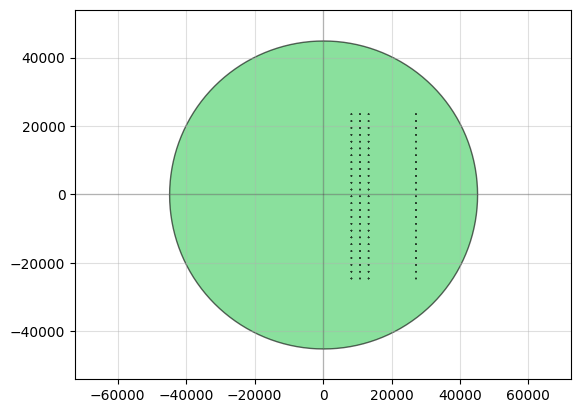

In [59]:

# Qubits 
# Define path to DXF file to import
qubit_chip_width = 2000 # um 
# path = r"C:\Users\eeshg\Documents\multimode_sims\Design\coupler"  # <-- UPDATE THIS
path = ''

with open("chip_names.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
dxf_files = chip_names_read
# x pos and y pos offsets for the qubit chips
xpos_offset = -7000 - 20000 + 1251.5 -1.5+1500  # um
ypos_offset = 500 + 4500 -1.5+1000  # um

# Import the GDS structure
for idx, file in enumerate(dxf_files):
    wafer, qubit_obj_gap, qubit_obj_pin = add_dxf_chip_to_wafer_junc(wafer, file, path, qubit_chip_width, idx, x_offset=xpos_offset, y_offset=ypos_offset, add_bool=True)
    
    qubit_obj_gap.rotate(-90)  # Rotate the qubit chip by 90 degrees
    qubit_obj_pin.rotate(-90)  # Rotate the qubit chip by 90 degrees
# Save the resulting wafer layout
wafer.write_gds("wafer_with_imported_dxf.gds")

# Quick preview (optional)
qp(wafer)



### Coupler

In [60]:
#Make the following code into a function : add bounding boxes and return negative mas 
# it should take arguments wafer, coupler_chip_obj, coupler_width, idx
# and return the wafer with the negative mask added
def add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset,
                                       ypos_offset):
    coupler_length = 48500
    test_structure_length = 4500

    xpos = xpos_offset + (idx * coupler_width)
    ypos = ypos_offset

    coupler_bbox = pg.rectangle(size=(coupler_width, coupler_length), layer=13)
    wafer << coupler_bbox.move((xpos - 100, ypos - 100))

    test_structure_bbox = pg.rectangle(size=(coupler_width, test_structure_length), layer=13)
    wafer << test_structure_bbox.move((xpos - 100, ypos + coupler_length - 100))

    coupler_chip_bbox = pg.rectangle(size=(coupler_width, coupler_length + test_structure_length), layer=14)
    coupler_chip_bbox.move((-100, -100))

    coupler_negative = pg.boolean(A=coupler_chip_bbox, B=coupler_chip_obj, operation='xor', layer=5)
    wafer << coupler_negative.move((xpos, ypos))

    return wafer

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJCOUPLER_JUNC_NO_DICE-C1A.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJCOUPLER_JUNC_NO_DICE-C1B.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJCOUPLER_JUNC_NO_DICE-C1C.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJCOUPLER_JUNC_NO_DICE-C1D.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJCOUPLER_JUNC_NO_DICE-C1E.gds
Layers in imported DXF: {np.int64(2), np.int64(3)}
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\Siraj1\designs_dxf\SIRAJCOUPLER_JUNC_NO_DICE-C1F.gds
Layers in imported DXF: {np.int64(2),

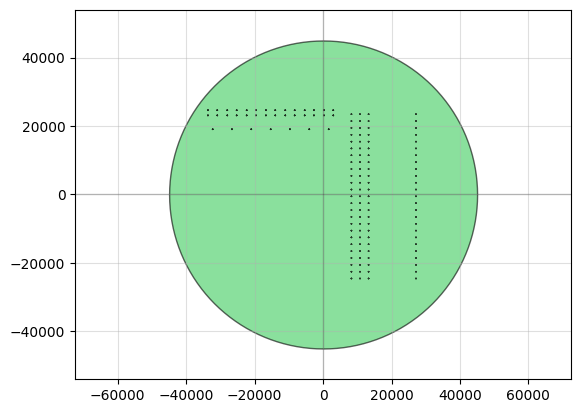

In [61]:
with open("chip_names_coup.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
coupler_files = chip_names_read
coupler_width = 5650
# Import the GDS structure
for idx, file in enumerate(coupler_files):
    wafer, coupler_gap, coupler_pin = add_dxf_chip_to_wafer_junc(wafer, file, path, coupler_width, idx, x_offset=-35000, y_offset=-27000,
                                                    add_bool = True)

    # wafer = add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=-35000, ypos_offset=-27000)
qp(wafer)

# Alignment Marks 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


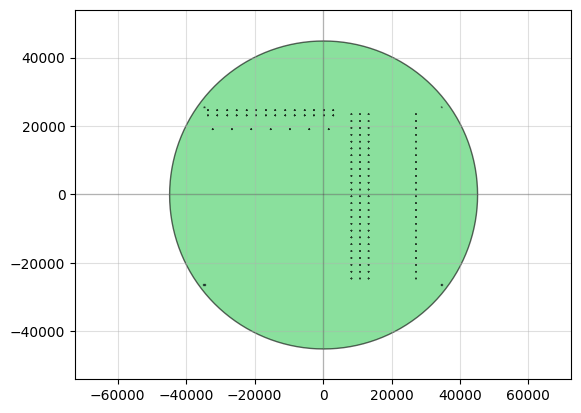

In [62]:
# Using Phidl draw a cross mark with line width of 20 micro at given point. Make a function . 
def draw_cross_mark(center=(0, 0), arm_length=100, line_width=20, layer=10):
    """
    Draws a cross mark centered at the given point.
    Args:
        center: tuple (x, y) for the center of the cross
        arm_length: length of each arm from center (um)
        line_width: width of the lines (um)
        layer: GDS layer to draw on
    Returns:
        phidl Device containing the cross mark
    """
    D = Device("cross_mark")
    x, y = center
    # Horizontal line
    h_line = pg.rectangle(size=(2 * arm_length, line_width), layer=layer)
    D << h_line.move((x - arm_length, y - line_width / 2))
    # Vertical line
    v_line = pg.rectangle(size=(line_width, 2 * arm_length), layer=layer)
    D << v_line.move((x - line_width / 2, y - arm_length))
    return D

# Example usage of draw_cross_mark
alignement_points = [(-34800, -26300), (-34800, 25600), (34540, 25600), (34540, -26300)]
for point in alignement_points:
    cross_mark = draw_cross_mark(center=(0,0), arm_length=160, line_width=20, layer=10)
    wafer << cross_mark.move(point)  # Place the cross mark at the specified point
# cross_mark = draw_cross_mark(center=(0, 0), arm_length=160, line_width=20, layer=10)
# wafer << cross_mark.move((0, 0))  # Place the cross mark at the origin
qp(wafer)  # Quick preview of the wafer with the cross mark

# Saving

In [ ]:
wafer.write_gds("SirajJuncs_skinny_juncs_no_dice.gds")

'SirajJuncs_skinny_juncs_no_dice.gds'

: 